In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from datetime import datetime
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 50000 instances
Validation set has 10000 instances


cat  car  ship  truck


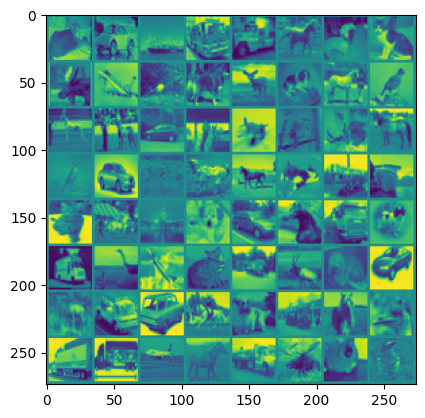

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [5]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # DIY: Design Layers -----------------------------------------


        # DIY: Design Layers -----------------------------------------

    def forward(self, x):
        # DIY: Forward Pass  -----------------------------------------


        # DIY: Forward Pass  -----------------------------------------
        return x


model = CNN()
summary(model, (3, 32, 32))


# DIY: Hyperparameters  -----------------------------------------
# Loss function
# loss_fn =
# Optimiter
# optimizer =
# DIY: Hyperparameters  -----------------------------------------


epoch_number = 0

EPOCHS = 20
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0 = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    model.train(True)
    for i, data in enumerate(training_loader):
        inputs, labels = data

        # DIY: Training Loop  -----------------------------------------




        # DIY: Training Loop  -----------------------------------------


        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    model.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    if valid_loss < best_vloss:
        best_vloss = valid_loss
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end = time.time()-t_0
print(f"Time consumption for non-accelerated CUDA training (CPU only): {t_end} sec")

# HW
ให้เติมโค้ดในส่วนที่กำหนดเพื่อให้สามารถรันโค้ดได้ตามปกติ
```
# DIY: A  -----------------------------------------
 < ----- ให้เขียนโค้ดในช่วงนี้
 < ----- ให้เขียนโค้ดในช่วงนี้
 < ----- ให้เขียนโค้ดในช่วงนี้
# DIY: A  -----------------------------------------
```
- ออกแบบและสร้าง โมเดล CNN ที่สามารถทำให้ Accuracy ≥ 50% บน Dataset ที่กำหนด
- เมื่อทำเสร็จแล้ว ให้ แคปภาพค่า Loss และ Accuracy ระหว่างการ Train
- บันทึกเป็นไฟล์ PDF และแนบมาพร้อมกับ ภาพแคป Layers ทั้งหมดของโมเดลที่ใช้